In [105]:
using LinearAlgebra
using Random
using Distributions
using ProgressMeter
using Statistics  

using Random
using LinearAlgebra
using Statistics
using Distributions
using ProgressMeter
using SpecialFunctions


using NLopt

using Plots
using StatsPlots  
using Distributions
using DataFrames

using XLSX
using DataFrames

In [106]:
function state_space(params)
    # Unpack parameters
    psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1,
    sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = params
    

    # State vector dimensions u_t B_t c_t c_t-1
    state_dim = 4

    

    # Observation matrix Z
    Z = zeros(state_dim)
    Z[1] = 1
    Z[end - 1] = 1

    # Innovation covariance matrix H
    H = 0

    # Transition matrix T
    T = zeros(state_dim, state_dim)
    T[1, 1] = 1  # u_t = u_{t-1} + beta_{t-1}
    T[1, 2] = 1
    T[2, 2] = 1  # beta_t = beta_{t-1} + xi_t
    T[3, 3] = psi1 # c_t = psi1 * c_{t-1} + psi2 * c_{t-2} + kappa_t
    T[3,4] = psi2 
    T[4, 3] = 1  #c_t-1 = c_{t}


    # State loading matrix R
    R = zeros(state_dim, state_dim)
    R[1, 1] = 1  # u_t = u_{t-1} + beta_{t-1} + epsilon_t
    R[2, 2] = 1  # beta_t = beta_{t-1} + xi_t
    R[3,3] = 1  

    # Process covariance matrices Q_0 and Q_1
    Q_0 = zeros(state_dim, state_dim)
    Q_0[1, 1] = sigma_epsilon2_0
    Q_0[2, 2] = sigma_xi2
    Q_0[3, 3] = sigma_kappa2_0 

    Q_1 = zeros(state_dim, state_dim)
    Q_1[1, 1] = sigma_epsilon2_1
    Q_1[2, 2] = sigma_xi2
    Q_1[3, 3] = sigma_kappa2_1 

    nu0 = zeros(state_dim)
    nu1 = zeros(state_dim)

    nu1[3] = omega
    

    return Z, H, T, R, Q_0, Q_1, nu0, nu1
end


state_space (generic function with 1 method)

In [107]:
function simulate_data(params, n_obs, alpha_init)
    Z, H, T, R, Q_0, Q_1, nu0, nu1 = state_space(params)
    
    psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1,
    sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = params

    state_dim = 4

    # Initialize state and observation vectors
    alpha = zeros(n_obs, state_dim)
    y = zeros(n_obs)
    # Initialize S_t
    S = zeros(Int, n_obs)

    # Initial state for S
    prob_S0 = [(1 - p) / (2 - p - q), (1 - q) / (2 - p - q)]
    S[1] = rand(Categorical(prob_S0))-1 #S is 0 or 1
    
    v = zeros(state_dim)
    if S[1] == 1  #Recesion
        # v = rand(MvNormal(zeros(state_dim), Q_1)) + nu1
        v[1] = rand(Normal(0, sqrt(params[7])))
        v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
        v[3] = rand(Normal(0, sqrt(params[5]))) #sigma kappa
        v = v + nu1
    else
        # v = rand(MvNormal(zeros(state_dim), Q_0)) + nu0
        v[1] = rand(Normal(0, sqrt(params[6]))) # sigma_epsilon
        v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
        v[3] = rand(Normal(0, sqrt(params[4]))) #sigma kappa
        v = v + nu0
    end
    alpha[1, :] = alpha_init + R * v
    y[1] = Z' * alpha[1, :] 

    # Simulate forwards
    for t in 2:n_obs
        if S[t - 1] == 1
            S[t] = rand(Categorical([1-p, p]))-1
        else
            S[t] = rand(Categorical([q, 1-q]))-1
        end

        v = zeros(state_dim)
        if S[t] == 1 #Recesion
            # v = rand(MvNormal(zeros(state_dim), Q_1)) + nu1
            v[1] = rand(Normal(0, sqrt(params[7]))) #sigma epsilon
            v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
            v[3] = rand(Normal(0, sqrt(params[5]))) #sigma kappa
            v = v + nu1

        else
            # v = rand(MvNormal(zeros(state_dim), Q_0)) + nu0
            v[1] = rand(Normal(0, sqrt(params[6]))) # sigma_epsilon
            v[2] = rand(Normal(0, sqrt(params[3])))  # sigma_xi2
            v[3] = rand(Normal(0, sqrt(params[4]))) #sigma kappa
            v = v + nu0
     

        end

        alpha[t, :] = T * alpha[t - 1, :] + R * v
        y[t] = Z' * alpha[t, :] 
    end

    return y, alpha
end

simulate_data (generic function with 1 method)

In [108]:
function switching_kalman_filter(y, params, a1, P1)

    Z, H, T, R, Q0, Q1, nu0, nu1 = state_space(params)
    psi1, psi2, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1,
    sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = params
    Q = [Q0, Q1]
    nu = [nu0, nu1]
    n = length(y)
    state_dim = 4

    # Initialize log-likelihood and initial state
    L = 0.0
    a_prev = zeros(2, state_dim)
    a_prev[1, :] = a1
    a_prev[2, :] = a1

    P_prev = zeros(2, state_dim, state_dim)
    P_prev[1, :, :] = P1
    P_prev[2, :, :] = P1

    # Initial probabilities
    p_S_ohm_prev = [(1 - p) / (2 - p - q), (1 - q) / (2 - p - q)]

    # Corrected definition of p_S_S
    p_S_S = zeros(2, 2)
    p_S_S[1, 1] = q # prob s = 0 given s = 0
    p_S_S[1, 2] = 1 - q # prob s = 1 given s = 0
    p_S_S[2, 1] = 1-p # prob s =0 given s = 1
    p_S_S[2, 2] = p # prob s = 1 given s = 1
    # List to store estimated states
    a_est_list = []

    S = [1, 2]  # Possible state index

    for t in 1:n
        # Initialize variables for current time step
        a_pred = zeros(2,2, state_dim)
        P_pred = zeros(2, 2, state_dim, state_dim)
        a_filt = zeros(2, 2, state_dim)
        P_filt = zeros(2, 2, state_dim, state_dim)
        v = zeros(2,2)
        F = zeros(2, 2)
        K = zeros(2, 2, state_dim)
        p_y_S_S_ohm = zeros(2, 2)
    

        for i in S
            for j in S
                # Prediction step
                a_pred_i_j = T * a_prev[i, :] + nu[j]
                P_prev_i = reshape(P_prev[i, :, :], state_dim, state_dim)
                P_pred_i_j = T * P_prev_i * T' + R * Q[j] * R'

                # Observation prediction
                y_pred = Z' * a_pred_i_j

                # Prediction error (innovation)
                v_i_j = y[t] - y_pred

                # Prediction error variance
                F_i_j = Z' * P_pred_i_j * Z + H

                # Kalman gain
                K_i_j = (P_pred_i_j * Z) / F_i_j  # Shape: (state_dim,)

                # Update state estimate
                a_filt_i_j = a_pred_i_j + K_i_j * v_i_j

                # Update covariance estimate
                P_filt_i_j = (I(state_dim) - K_i_j * Z') * P_pred_i_j

                # Store results
                a_pred[i,j, :] = a_pred_i_j
                P_pred[i, j, :, :] = P_pred_i_j
                a_filt[i, j, :] = a_filt_i_j
                P_filt[i, j, :, :] = P_filt_i_j
                v[i,j] = v_i_j
                F[i, j] = F_i_j
                K[i, j, :] = K_i_j

                # Compute p(y_t | S_{t-1}=i, S_t=j, Ψ_{t-1})
                p_y_S_S_ohm[i, j] = (1 / sqrt(2 * π * F[i,j])) * exp(-0.5 * v[i,j]^2 / F[i,j])
            end
        end


        # Compute p(y_t | Ψ_{t-1})
        p_S_S_ohm_prev = zeros(2, 2)
        for i in S
            for j in S
                p_S_S_ohm_prev[i, j] = p_S_ohm_prev[i] * p_S_S[i, j]
            end
        end

        p_y_ohm_t = sum(p_S_S_ohm_prev .* p_y_S_S_ohm)
        L += log(p_y_ohm_t)

        # Update probabilities
        p_S_S_ohm_t = (p_S_S_ohm_prev .* p_y_S_S_ohm) / p_y_ohm_t
        p_S_ohm_t = vec(sum(p_S_S_ohm_t, dims=1))

        # Combine filtered estimates
        a_t = zeros(2, state_dim)
        P_t = zeros(2, state_dim, state_dim)

        for j in S
            numerator_a = zeros(state_dim)
            denominator = p_S_ohm_t[j]
            for i in S
                numerator_a += p_S_S_ohm_t[i, j] * a_filt[i, j, :]
            end
            a_t_j = numerator_a / denominator
            a_t[j, :] = a_t_j

            numerator_P = zeros(state_dim, state_dim)
            for i in S
                diff = a_t_j - a_filt[i, j, :]
                P_filt_i_j = reshape(P_filt[i, j, :, :], state_dim, state_dim)
                numerator_P += p_S_S_ohm_t[i, j] * (P_filt_i_j + diff * diff')
            end
            P_t[j, :, :] = numerator_P / denominator
        end

        # Estimate state
        a_est_t = zeros(state_dim)
        for j in S
            a_est_t += p_S_ohm_t[j] * a_t[j, :]
        end
        push!(a_est_list, a_est_t)

        # Prepare for next iteration
        a_prev = a_t
        P_prev = P_t
        p_S_ohm_prev = p_S_ohm_t
    end

    # Convert a_est_list to array
    a_est = hcat(a_est_list...)'  # Each row corresponds to a time step
    return L, a_est
end


switching_kalman_filter (generic function with 1 method)

In [109]:
function neg_log_likelihood(params, y, a1, P1)
    logL, a = switching_kalman_filter(y, params, a1, P1)
    return -logL
end


neg_log_likelihood (generic function with 1 method)

## MCMC Functions

In [110]:
function transform_params(params_unbounded, priors)
    # Unpack parameters
    gamma_rho, gamma_lambda_c, gamma_sigma_xi2, gamma_sigma_kappa2_0, gamma_sigma_kappa2_1, gamma_sigma_epsilon2_0, gamma_sigma_epsilon2_1, gamma_omega, gamma_p, gamma_q = params_unbounded
    a_rho, b_rho, a_lambda, b_lambda, a_xi, b_xi, a_kappa_0, b_kappa_0, a_kappa_1, b_kappa_1, a_epsilon_0, b_epsilon_0, a_epsilon_1, b_epsilon_1, a_omega, b_omega, a_p, b_p, a_q, b_q = priors


    # Transform gamma_rho (Uniform transformation for rho)
    exp_gamma_rho = exp(gamma_rho)
    rho = (a_rho + b_rho * exp_gamma_rho) / (1 + exp_gamma_rho)

    # Transform gamma_lambda_c (Uniform transformation for lambda_c)
    exp_gamma_lambda = exp(gamma_lambda_c)
    lambda_c = (a_lambda + b_lambda * exp_gamma_lambda) / (1 + exp_gamma_lambda)

    #Transform p and q (Uniform transformation for p and q)
    exp_gamma_p = exp(gamma_p)
    p = (a_p + b_p * exp_gamma_p) / (1 + exp_gamma_p)
    exp_gamma_q = exp(gamma_q)
    q = (a_p + b_p * exp_gamma_q) / (1 + exp_gamma_q)

    # Transform variance parameters (Inverse-Gamma transformation)
    sigma_xi2 = exp(gamma_sigma_xi2)
    sigma_kappa2_0 = exp(gamma_sigma_kappa2_0)
    sigma_kappa2_1 = exp(gamma_sigma_kappa2_1)
    sigma_epsilon2_0 = exp(gamma_sigma_epsilon2_0)
    sigma_epsilon2_1 = exp(gamma_sigma_epsilon2_1)

    # transform omega (normal)
    omega = gamma_omega

    return (rho, lambda_c, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1, sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q)

end

transform_params (generic function with 1 method)

In [111]:
function log_derivatives_params(params_unbounded, priors)
    # Unpack parameters
    gamma_rho, gamma_lambda_c, gamma_sigma_xi2, gamma_sigma_kappa2_0, gamma_sigma_kappa2_1, gamma_sigma_epsilon2_0, gamma_sigma_epsilon2_1, gamma_omega, gamma_p, gamma_q = params_unbounded
    a_rho, b_rho, a_lambda, b_lambda, a_xi, b_xi, a_kappa_0, b_kappa_0, a_kappa_1, b_kappa_1, a_epsilon_0, b_epsilon_0, a_epsilon_1, b_epsilon_1, a_omega, b_omega, a_p, b_p, a_q, b_q = priors
    
    # Log derivative for rho
    log_derivative_rho = log(b_rho - a_rho) + gamma_rho - 2 * log(1 + exp(gamma_rho))
    # Log derivative for lambda_c
    log_derivative_lambda_c = log(b_lambda - a_lambda) + gamma_lambda_c - 2 * log(1 + exp(gamma_lambda_c))
    # Log derivatives for p and q
    log_derivative_p = log(b_p - a_p) + gamma_p - 2 * log(1 + exp(gamma_p))
    log_derivative_q = log(b_p - a_p) + gamma_q - 2 * log(1 + exp(gamma_q))

    # Log derivatives for variance parameters
    log_derivative_sigma_xi2 = gamma_sigma_xi2
    log_derivative_sigma_kappa2_0 = gamma_sigma_kappa2_0
    log_derivative_sigma_kappa2_1 = gamma_sigma_kappa2_1
    log_derivative_sigma_epsilon2_0 = gamma_sigma_epsilon2_0
    log_derivative_sigma_epsilon2_1 = gamma_sigma_epsilon2_1

    # Log derivative for omega
    log_derivative_omega = 0
 

    return (log_derivative_lambda_c, log_derivative_rho, log_derivative_sigma_xi2, log_derivative_sigma_kappa2_0, log_derivative_sigma_kappa2_1, log_derivative_sigma_epsilon2_0, log_derivative_sigma_epsilon2_1, log_derivative_omega, log_derivative_p, log_derivative_q)
    
end

log_derivatives_params (generic function with 1 method)

In [112]:
function log_prior(theta, priors)
    # Unpack parameters
    rho, lambda_c, sigma_xi2, sigma_kappa2_0, sigma_kappa2_1, sigma_epsilon2_0, sigma_epsilon2_1, omega, p, q = theta
    a_rho, b_rho, a_lambda, b_lambda, a_xi, b_xi, a_kappa_0, b_kappa_0, a_kappa_1, b_kappa_1, a_epsilon_0, b_epsilon_0, a_epsilon_1, b_epsilon_1, a_omega, b_omega, a_p, b_p, a_q, b_q = priors

    # Log prior rho (uniform 0 to 0.999)
    log_prior_rho = log(1 / (b_rho - a_rho))

    # Log prior lambda_c (uniform 0 to π)
    log_prior_lambda_c = log(1 / (b_lambda - a_lambda))

    # Log prior p and q (uniform 0 to 1)
    log_prior_p = log(1 / (b_p - a_p))
    log_prior_q = log(1 / (b_q - a_q))

    # Inverse-Gamma priors for variance parameters
    log_prior_sigma_xi2 = a_xi* log(b_xi) - lgamma(a_xi) - (a_xi + 1) * log(sigma_xi2) - b_xi / sigma_xi2
    log_prior_sigma_kappa2_0 = a_kappa_0 * log(b_kappa_0) - lgamma(a_kappa_0) - (a_kappa_0 + 1) * log(sigma_kappa2_0) - b_kappa_0 / sigma_kappa2_0
    log_prior_sigma_kappa2_1 = a_kappa_1 * log(b_kappa_1) - lgamma(a_kappa_1) - (a_kappa_1 + 1) * log(sigma_kappa2_1) - b_kappa_1 / sigma_kappa2_1
    log_prior_sigma_epsilon2_0 = a_epsilon_0 * log(b_epsilon_0) - lgamma(a_epsilon_0) - (a_epsilon_0 + 1) * log(sigma_epsilon2_0) - b_epsilon_0 / sigma_epsilon2_0
    log_prior_sigma_epsilon2_1 = a_epsilon_1 * log(b_epsilon_1) - lgamma(a_epsilon_1) - (a_epsilon_1 + 1) * log(sigma_epsilon2_1) - b_epsilon_1 / sigma_epsilon2_1
   
    # log prior omega (normal mean a_omea, var b_omega)
    log_prior_omega = -0.5 * log(2 * π * b_omega) - 0.5 * (omega - a_omega)^2 / b_omega

    return log_prior_rho + log_prior_lambda_c + log_prior_sigma_xi2 + log_prior_sigma_kappa2_0 + log_prior_sigma_kappa2_1 + log_prior_sigma_epsilon2_0 + log_prior_sigma_epsilon2_1 + log_prior_omega + log_prior_p + log_prior_q
    
end

log_prior (generic function with 1 method)

In [113]:
function log_posterior(gamma, priors, y, a1, P1)
    theta = transform_params(gamma, priors)
    
    log_lik, a_est = switching_kalman_filter(y, theta, a1, P1)
 
    log_pri = log_prior(theta, priors)

    if log_pri == -Inf || isnan(log_lik)
        return -Inf
    end

    log_jacobian = sum(log_derivatives_params(gamma, priors))

    return log_lik + log_pri + log_jacobian
end

log_posterior (generic function with 1 method)

In [114]:
function initialize_mcmc(y, priors, a1, P1; n_init=40000, burn_init=5000, omega_init=0.1)
    dim = 10  # Number of parameters

    # Initialize storage for the chain
    chain_init = zeros(n_init, dim)
    current_gamma = zeros(dim)  # Initial value for gamma
    current_log_post = log_posterior(current_gamma, priors, y, a1, P1)

    accept_init = 0

    pb = Progress(n_init; desc="Initialization Phase")

    for s in 1:n_init
        # Propose Gamma*
        gamma_star = rand(MvNormal(current_gamma, omega_init * I(dim)))

        # Compute log posterior
        log_post_star = log_posterior(gamma_star, priors, y, a1, P1)

        # Acceptance probability
        if log_post_star == -Inf
            eta = 0
        else
            eta = min(1, exp(log_post_star - current_log_post))
        end

        # Accept or reject
        if rand() < eta
            chain_init[s, :] = gamma_star
            current_gamma = gamma_star
            current_log_post = log_post_star
            accept_init += 1
        else
            chain_init[s, :] = current_gamma
        end

        next!(pb)
    end

    acceptance_rate_init = accept_init / n_init
    println("Initialization Acceptance Rate: $(acceptance_rate_init * 100) %")

    # Discard burn-in
    chain_init_burned = chain_init[burn_init+1:end, :]

    # Compute covariance matrix from initialization
    Sigma = cov(chain_init_burned)

    return chain_init_burned, Sigma, acceptance_rate_init
end


initialize_mcmc (generic function with 1 method)

In [115]:
function recursion_mcmc(y, priors, a1, P1, chain_init_burned, Sigma; n_rec=20000, burn_rec=10000, omega_rec=0.1)
    dim = 10  # Number of parameters


    # Initialize storage for the recursion chain
    chain_rec = zeros(n_rec, dim)
    theta_samples = zeros(n_rec, dim)

    # Start from the last point of the initialization chain
    current_gamma_rec = copy(chain_init_burned[end, :])
    current_log_post_rec = log_posterior(current_gamma_rec, priors, y, a1, P1)
    
    accept_rec = 0

    # Placeholder for alphas
    state_dim = 4
    alphas = []

    pb = Progress(n_rec; desc="Recursion Phase")

    for q in 1:n_rec
        # Propose Gamma*
        gamma_star = rand(MvNormal(current_gamma_rec, omega_rec * Sigma))
        # gamma_star = rand(MvNormal(current_gamma_rec, omega_rec * I(dim)))
        
        # Compute log posterior
        log_post_star = log_posterior(gamma_star,priors, y, a1, P1)
        
        # Acceptance probability
        if log_post_star == -Inf
            eta = 0
        else
            eta = min(1, exp(log_post_star - current_log_post_rec))
        end
        
        # Accept or reject
        if rand() < eta
            chain_rec[q, :] = gamma_star
            current_gamma_rec = gamma_star
            current_log_post_rec = log_post_star
            accept_rec += 1
        else
            chain_rec[q, :] = current_gamma_rec
        end
        
        theta_samples[q, :] = collect(transform_params(current_gamma_rec,priors))


        #After burn-in, perform Gibbs sampling for states
        if q >= (burn_rec)
            theta = transform_params(current_gamma_rec,priors)

            _, alpha_star = switching_kalman_filter(y, theta, a1, P1)
            
            # Store the sampled alpha
            push!(alphas, alpha_star)
        end

        next!(pb)
    end

    acceptance_rate_rec = accept_rec / n_rec
    println("Recursion Acceptance Rate: $(acceptance_rate_rec * 100) %")

    # Discard burn-in
    chain_rec_burned = chain_rec[burn_rec+1:end, :]
    theta_samples_burned = theta_samples[burn_rec+1:end, :]

    # Collect the sampled alphas
    alpha_samples = alphas[2:end-1]

    return theta_samples_burned, alpha_samples, acceptance_rate_rec
end



recursion_mcmc (generic function with 1 method)

## Estimate

In [116]:
# Specify the file path and sheet name
file_path = "quarterly_gdp.xlsx"
sheet_name = "Quarterly GDP"

# Open the Excel file and load the data from the specified sheet into a DataFrame
data = XLSX.readtable(file_path, sheet_name) |> DataFrame

# Display data
println(data)

# Get the number of observations
num_obs = size(data, 1)
println("Number of observations: ", num_obs)




134×2 DataFrame
 Row │ Date    Value 
     │ Any     Any   
─────┼───────────────
   1 │ 1991K1  364.6
   2 │ 1991K2  364.7
   3 │ 1991K3  368.6
   4 │ 1991K4  364.5
   5 │ 1992K1  371.5
   6 │ 1992K2  367.9
   7 │ 1992K3  377.2
   8 │ 1992K4  375.4
   9 │ 1993K1  371.8
  10 │ 1993K2  370
  11 │ 1993K3  373.2
  12 │ 1993K4  375.7
  13 │ 1994K1  385.1
  14 │ 1994K2  391.5
  15 │ 1994K3  393.3
  16 │ 1994K4  399.8
  17 │ 1995K1  404.2
  18 │ 1995K2  402.5
  19 │ 1995K3  404
  20 │ 1995K4  406.7
  21 │ 1996K1  407.8
  22 │ 1996K2  418.3
  23 │ 1996K3  419
  24 │ 1996K4  419.1
  25 │ 1997K1  424.8
  26 │ 1997K2  431.6
  27 │ 1997K3  429.7
  28 │ 1997K4  430.9
  29 │ 1998K1  437.5
  30 │ 1998K2  434
  31 │ 1998K3  441.2
  32 │ 1998K4  444.1
  33 │ 1999K1  447.8
  34 │ 1999K2  449.8
  35 │ 1999K3  451.7
  36 │ 1999K4  459.7
  37 │ 2000K1  462.9
  38 │ 2000K2  468.1
  39 │ 2000K3  468.9
  40 │ 2000K4  476.5
  41 │ 2001K1  469.1
  42 │ 2001K2  472.2
  43 │ 2001K3  475.3
  44 │ 2001K4  477.7
  

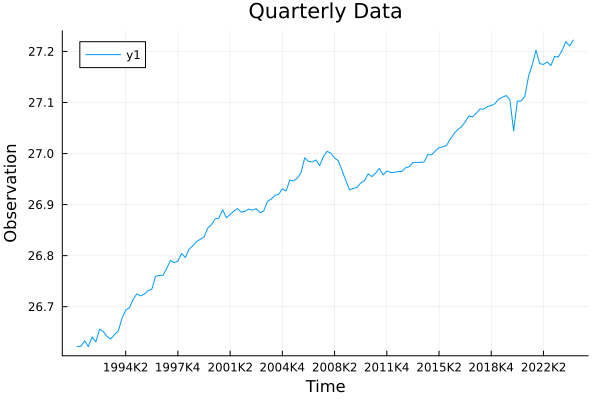

attempt to save state beyond implementation limit


In [117]:
y = data[:, 2]*1e9
y = log.(y)
dates = data[:, 1]

# Plot the data
plot(dates,y, title="Quarterly Data", xlabel="Time", ylabel="Observation")

In [ ]:
#Define model
state_dim = 4
alpha_init = zeros(state_dim)
alpha_init[1] = y[1]
P1 = Matrix{Float64}(I(state_dim))*100  # Initial covariance matrix

#Priors
a_psi1 = 0.01
b_psi1 = 0.97
a_psi2 = 0.01
b_psi2 = 0.97
a_xi = 3
b_xi = 0.0005
a_kappa_0 = 3
b_kappa_0 = 0.01
a_kappa_1 = 3
b_kappa_1 = 0.01
a_epsilon_0 = 3
b_epsilon_0 = 0.01
a_epsilon_1 = 3
b_epsilon_1 = 0.01
a_omega = -0.5
b_omega = 0.1
a_p = 0.01
b_p = 0.99
a_q = 0.01
b_q = 0.99
priors = [a_psi1, b_psi1, a_psi2, b_psi2, a_xi, b_xi, a_kappa_0, b_kappa_0, a_kappa_1, b_kappa_1, a_epsilon_0, b_epsilon_0, a_epsilon_1, b_epsilon_1, a_omega, b_omega, a_p, b_p, a_q, b_q]




20-element Vector{Float64}:
  0.01
  0.97
  0.1
  3.141592653589793
  3.0
  0.0005
  3.0
  0.01
  3.0
  0.01
  3.0
  0.01
  3.0
  0.01
 -0.5
  0.1
  0.01
  0.99
  0.01
  0.99

In [119]:
# Run MCMC initialization
chain_init_burned, Sigma, acceptance_rate_init = initialize_mcmc(
    y,
    priors,
    alpha_init, 
    P1; 
    n_init=10000, 
    burn_init=5000, 
    omega_init=0.03)

Initialization Phase 100%|███████████████████████████████| Time: 0:00:22


Initialization Acceptance Rate: 21.83 %


([1.7227570806511479 -4.051435122406547 … 3.608176292739639 0.3315522610743954; 1.7138160290180933 -4.075754255974279 … 3.778339984031925 0.14553437107686001; … ; 1.6682048812167865 -3.5798818392949396 … 5.2846520716888925 1.0574103843999112; 1.6682048812167865 -3.5798818392949396 … 5.2846520716888925 1.0574103843999112], [0.33436844548157324 -0.5155594863757454 … -0.034726449081033 0.07090461597533329; -0.5155594863757454 0.9717824942412178 … 0.11357830619280612 -0.10931666667512502; … ; -0.034726449081033 0.11357830619280612 … 0.554297134652058 0.2734802738397901; 0.07090461597533329 -0.10931666667512502 … 0.2734802738397901 0.9943731195111074], 0.2183)

In [120]:
# Run MCMC recursion
theta_samples_burned, alpha_samples, acceptance_rate_rec = recursion_mcmc(
    y, 
    priors,
    alpha_init, 
    P1, 
    chain_init_burned, 
    Sigma; 
    n_rec=10000, 
    burn_rec=5000, 
    omega_rec=0.06)


Recursion Phase 100%|████████████████████████████████████| Time: 0:00:30


Recursion Acceptance Rate: 52.38 %


([0.6091484148244254 0.20170669276130046 … 0.9706164240718802 0.14886772401452722; 0.5906330454730906 0.23299937686898878 … 0.9714339974234204 0.14600886982675626; … ; 0.8593544722049318 0.13756038094150366 … 0.9804470642097185 0.21084936205843638; 0.8555207933430211 0.13660727091855845 … 0.9811031307901928 0.2925665263307262], Any[[26.66509529804973 0.02151425198721621 -0.043028598858757955 0.013105372494145999; 26.701015208940202 0.03229272805746429 -0.07867427417915795 -0.04665575477051981; … ; 27.49510094152463 0.005544232973301701 -0.2841510860936059 -0.2761511626257731; 27.503886896514015 0.006373044531200547 -0.2815861814143071 -0.2854080589023761], [26.690497897850353 0.034215525237870414 -0.06843119865938263 0.020208819873704792; 26.74458041786499 0.04926458845257151 -0.12223948310394483 -0.073249103219876; … ; 27.69309270752696 0.005577458923505145 -0.4821428520959386 -0.4741379281446885; 27.701669526370576 0.00634718537484781 -0.4793688112708654 -0.48332462375520574], [26.69

In [122]:
parameters = ["psi1", "psi2", "sigma_xi2", "sigma_kappa2_0", "sigma_kappa2_1",
              "sigma_epsilon2_0", "sigma_epsilon2_1", "omega", "p", "q"]

n_params = length(parameters)

10

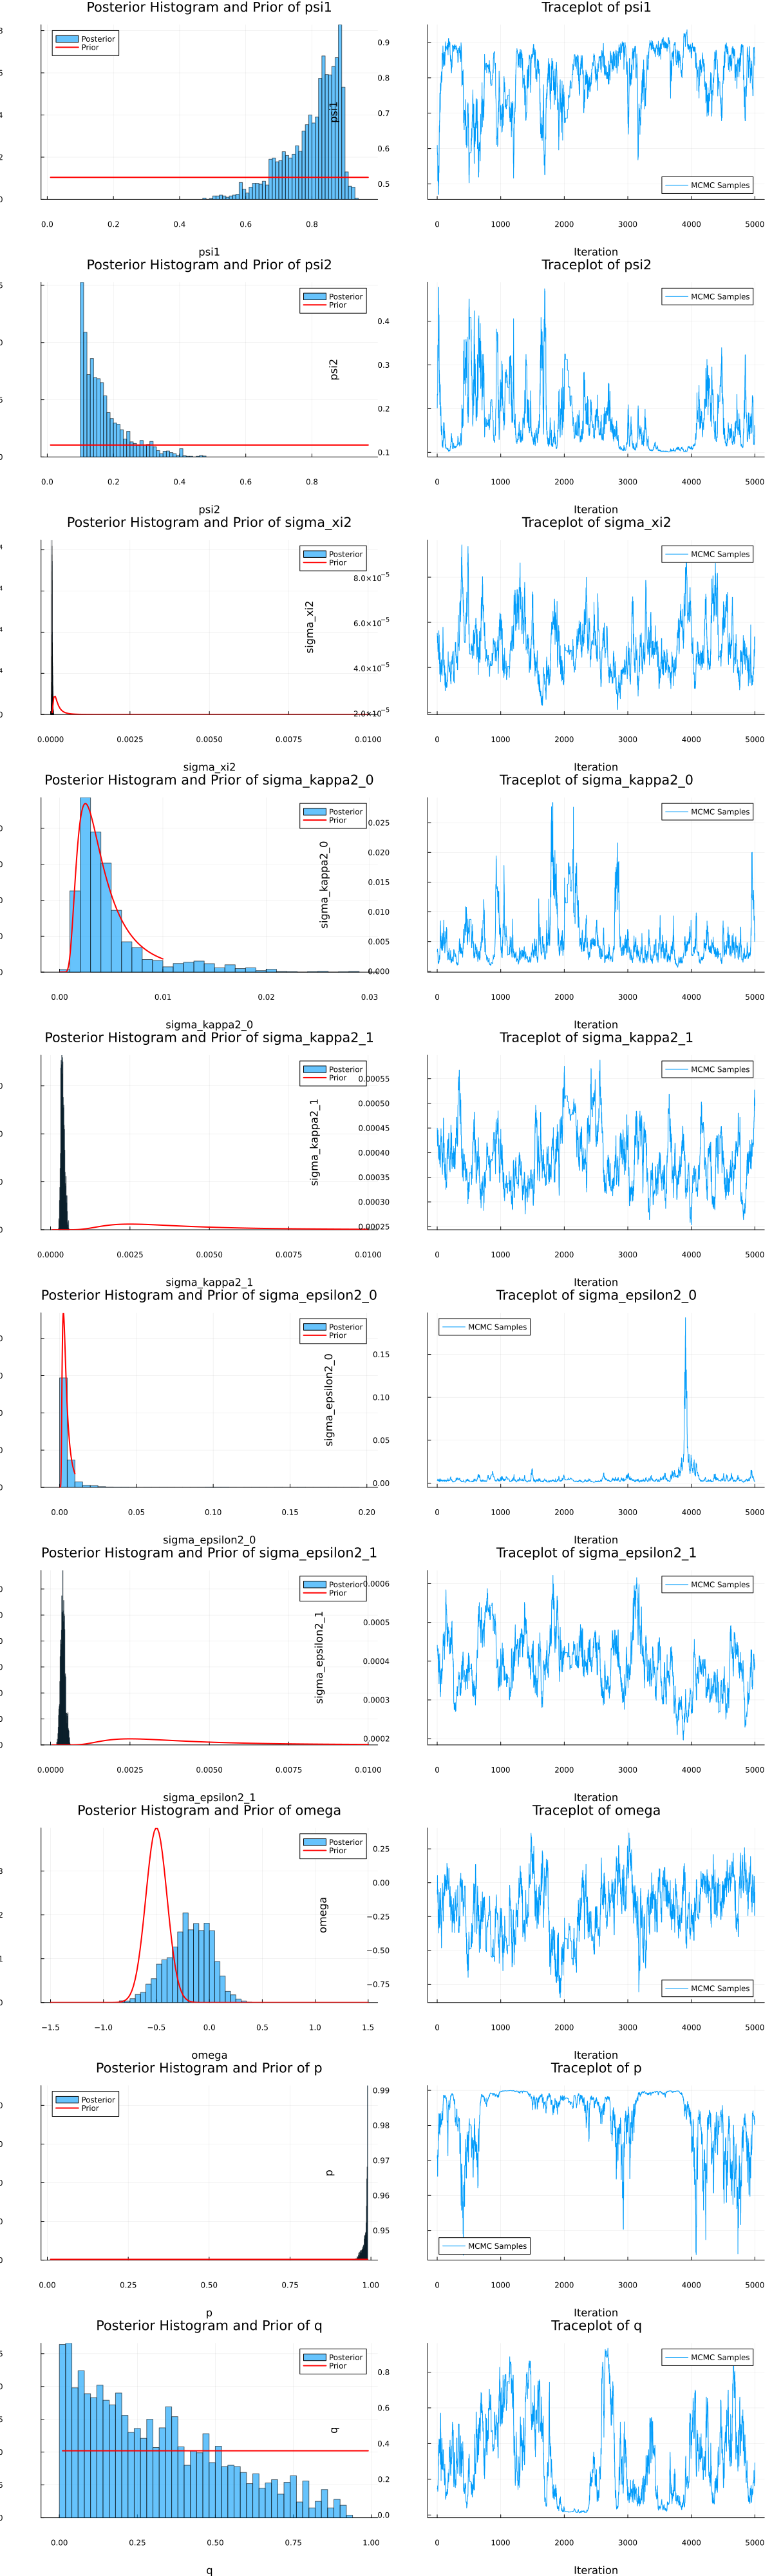

In [123]:
# Initialize a list to hold the plots
p_list = []

for i in 1:n_params
    param_samples = theta_samples_burned[:, i]
    
    # Histogram of posterior samples
    p1 = histogram(param_samples, bins=50, normalize=true, alpha=0.6,
                   label="Posterior", xlabel=parameters[i], ylabel="Density",
                   title="Posterior Histogram and Prior of $(parameters[i])")
    
    # Define the prior distribution
    if parameters[i] == "psi1"
        # Uniform prior between 0 and 0.999
        a = a_psi1
        b = b_psi1
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] == "psi2"
        # Uniform prior between 0 and π
        a = a_psi2
        b = b_psi2
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] in ["p", "q"]
        # Uniform prior between 0 and 1
        a = a_p
        b = b_p
        x_values = range(a, b, length=200)
        prior_pdf = pdf.(Uniform(a, b), x_values)
    elseif parameters[i] == "omega"
        a = a_omega
        b = b_omega
        x_values = range(-1.5, 1.5, length=200)
        prior_pdf = pdf.(Normal(a, b), x_values)
    elseif parameters[i] == "sigma_xi2"
        a = a_xi
        b = b_xi
        x_values = range(0, 0.01, length=200)
        prior_pdf = pdf.(InverseGamma(a, b), x_values)
    elseif parameters[i] == "sigma_kappa2_0"
        a = a_kappa_0
        b = b_kappa_0
        x_values = range(0, 0.01, length=200)
        prior_pdf = pdf.(InverseGamma(a, b), x_values)
    elseif parameters[i] == "sigma_kappa2_1"
        a = a_kappa_1
        b = b_kappa_1
        x_values = range(0, 0.01, length=200)
        prior_pdf = pdf.(InverseGamma(a, b), x_values)
    elseif parameters[i] == "sigma_epsilon2_0"
        a = a_epsilon_0
        b = b_epsilon_0
        x_values = range(0, 0.01, length=200)
        prior_pdf = pdf.(InverseGamma(a, b), x_values)
    elseif parameters[i] == "sigma_epsilon2_1"
        a = a_epsilon_1
        b = b_epsilon_1
        x_values = range(0, 0.01, length=200)
        prior_pdf = pdf.(InverseGamma(a, b), x_values)

    end
    
    # Overlay prior PDF on histogram
    plot!(p1, x_values, prior_pdf, label="Prior", color=:red, linewidth=2)
        
    # Traceplot of MCMC samples
    p2 = plot(param_samples, label="MCMC Samples", xlabel="Iteration", ylabel=parameters[i],
              title="Traceplot of $(parameters[i])")
    
    # Add plots to the list
    push!(p_list, p1)
    push!(p_list, p2)
end

# Display the plots in a grid layout
nrows = n_params
ncols = 2
plot(p_list..., layout=(nrows, ncols), size=(1200, 400 * n_params))


In [124]:
# Calculate means of posterior samples
chain_rec_burned_means = mean(theta_samples_burned, dims=1)  # 1 x n_params array
chain_rec_burned_means = vec(chain_rec_burned_means)  # Convert to a vector


10-element Vector{Float64}:
  0.8028751512884348
  0.17186200269977012
  4.8752878251317195e-5
  0.004907645286056263
  0.0003858410811451894
  0.005828262700376358
  0.0003909396269759167
 -0.19162223587405408
  0.9827168647590097
  0.30662135089034337

In [125]:

# Create the DataFrame
data = DataFrame(Dict(
    "Parameter" => parameters,
    "MCMC Estimate" => chain_rec_burned_means,
    # "MLE Estimate" => best_params,  # Include if available
))

# Display the DataFrame
display(data)


10×2 DataFrame
 Row │ MCMC Estimate  Parameter        
     │ Float64        String           
─────┼─────────────────────────────────
   1 │   0.802875     psi1
   2 │   0.171862     psi2
   3 │   4.87529e-5   sigma_xi2
   4 │   0.00490765   sigma_kappa2_0
   5 │   0.000385841  sigma_kappa2_1
   6 │   0.00582826   sigma_epsilon2_0
   7 │   0.00039094   sigma_epsilon2_1
   8 │  -0.191622     omega
   9 │   0.982717     p
  10 │   0.306621     q

134
134


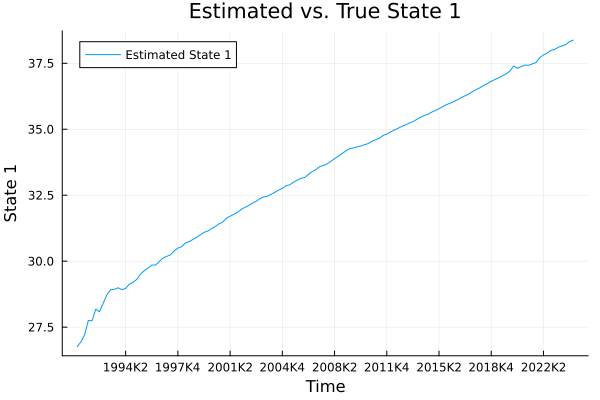

attempt to save state beyond implementation limit


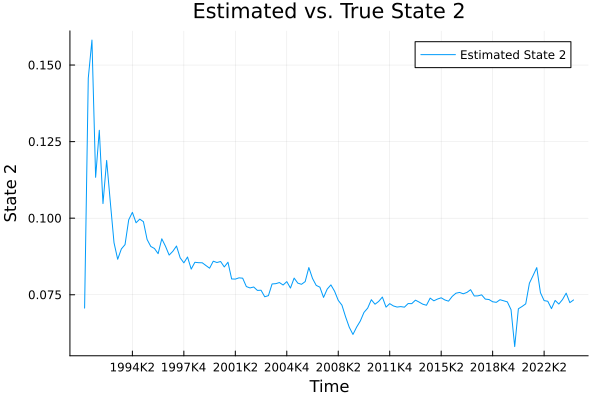

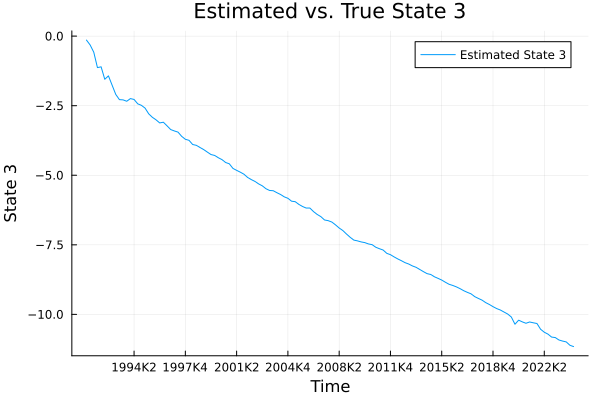

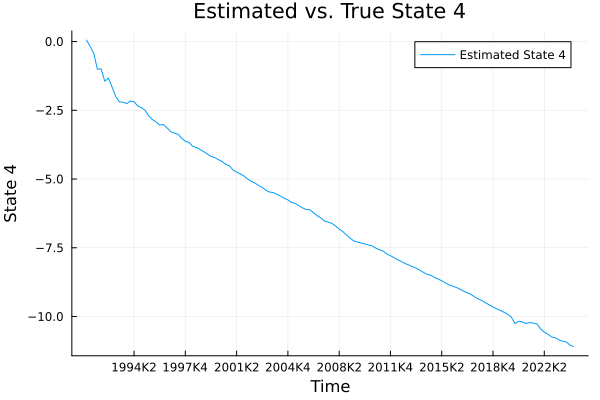

In [130]:
# Collect alpha samples into a 3D array
n_samples = length(alpha_samples)
n_time_steps = size(alpha_samples[1], 1)
state_dim = size(alpha_samples[1], 2)

dates_plot = dates

println(n_time_steps)
println(length(dates_plot))

# Initialize array to hold alpha samples
alpha_samples_array = Array{Float64}(undef, n_samples, n_time_steps, state_dim)

for i in 1:n_samples
    alpha_samples_array[i, :, :] = alpha_samples[i]
end


# Compute posterior mean over samples (dimension 1)
alpha_mean = mean(alpha_samples_array, dims=1)  # 1 x n_time_steps x state_dim
alpha_mean = dropdims(alpha_mean; dims=1)  # n_time_steps x state_dim

# Compute credible intervals
alpha_lower = mapslices(x -> quantile(x, 0.025), alpha_samples_array; dims=1)
alpha_lower = dropdims(alpha_lower; dims=1)
alpha_upper = mapslices(x -> quantile(x, 0.975), alpha_samples_array; dims=1)
alpha_upper = dropdims(alpha_upper; dims=1)



time = 1:n_time_steps

for s in 1:state_dim
    p = plot(dates_plot, alpha_mean[:, s], label="Estimated State $(s)", xlabel="Time",
             ylabel="State $(s)", title="Estimated vs. True State $(s)")
    
    # Add credible intervals using the `ribbon` argument
    # plot!(dates_plot, alpha_mean[:, s], ribbon=(alpha_mean[:, s] .- alpha_lower[:, s],
    #       alpha_upper[:, s] .- alpha_mean[:, s]), fillalpha=0.3, label="95% Credible Interval")
    
    # # Plot true state (assuming you have `alpha_true` from data simulation)
    # plot!(time, alpha[1:n_time_steps, s], label="True State $(s)", linestyle=:dash, color=:red)
    
    display(p)
end


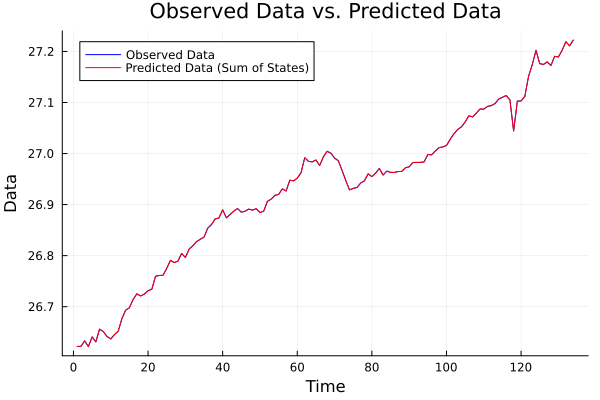

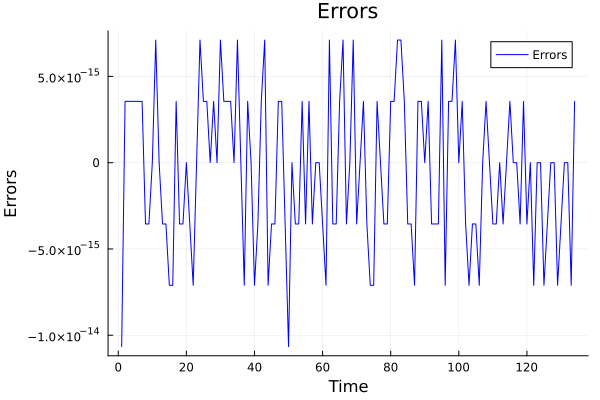

In [131]:
# Compute y_pred
state_indices = [1, 3]  # Adjust as necessary

y_pred = alpha_mean[:, state_indices[1]] .+ alpha_mean[:, state_indices[2]]

time = 1:length(y_pred)
y_adjusted = y[1:length(y_pred)]  # Adjust if lengths differ

p = plot(time, y_adjusted, label="Observed Data", color=:blue)
plot!(p, time, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted Data")
display(p)


errors = y_adjusted .- y_pred

p_error = plot(time, errors, label="Errors", color=:blue)
xlabel!("Time")
ylabel!("Errors")
title!("Errors")
display(p_error)


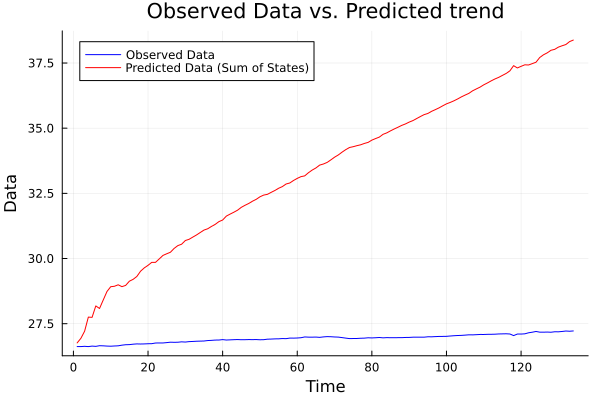

In [132]:
# estimated state 1 and true observation y
# Compute y_pred
state_indices = [1, 3]  # Adjust as necessary

y_pred = alpha_mean[:, state_indices[1]] 

time = 1:length(y_pred)
y_adjusted = y[1:length(y_pred)]  # Adjust if lengths differ

p = plot(time, y_adjusted, label="Observed Data", color=:blue)
plot!(p, time, y_pred, label="Predicted Data (Sum of States)", color=:red)
xlabel!("Time")
ylabel!("Data")
title!("Observed Data vs. Predicted trend")
display(p)



